# Q1: Math

# Q2: Orthogonal Learning

In [5]:
import Pkg
Pkg.add("Distributions") 
Pkg.add("DataFrames")
Pkg.add("CSV")
Pkg.add("Tables")
Pkg.add("GLM")
Pkg.add("CovarianceMatrices") 
Pkg.add("Gadfly")
Pkg.add("Lasso")

using Distributions
using DataFrames
using CSV
using Tables
using GLM
using CovarianceMatrices
using Gadfly
using Lasso
#include("../hdmjl.jl")
include("../Julia_Notebooks/hdmjl/hdmjl.jl")

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolvi

#### Code for each iteration

In [3]:
n = 10000
p = 100
beta = 1 ./ (1:p).^2    #px1 vector
gamma = 1 ./ (1:p).^2   #px1 vector
X = rand(Normal(0,1), n, p) #nxp matrix
D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
X1 = hcat(D,X)

#---As DataFrames---#
colnames_X = []
colnames_D = [:D]
colnames_Y = [:Y]
colnames_X1 = [:D]
for i in 1:100
    push!(colnames_X, Symbol("x$i"))
    push!(colnames_X1, Symbol("x$i"))
end
X_df = DataFrame(X, colnames_X)
D_df = DataFrame(D, colnames_D)
Y_df = DataFrame(Y, colnames_Y)
X1_df = DataFrame(X1, colnames_X1)


#--------------#
#---NAIVE------#
#--------------#
model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

coef1 = rlasso(model1)["coefficients"][3:102,2]                    #elements 1 and 2 are the intercept and D's coefficient 
SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0

#If all coefficients from X are 0
if (all(coef1[SX_IDs, :] .==0)) 
    Y1 = hcat(Y_df, D_df)
    print(coef(lm(@formula(Y ~ D), Y1))[2]) #enlace con Naive
end

#If some coefficients from X are non-zero
if (any(coef1[SX_IDs, :] .!=0))

    Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])

    #Generating formula
    varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    print(coef(lm(expression, Y2))[2]) #enlace con Naive

end

#-------------------#
#---ORTHOGONAL------#
#-------------------#
model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
Y3=DataFrame(hcat(resY,resD),["resY","resD"])

coef(lm(@formula(resY ~ resD), Y3))[2] #enlace orthogonal

10.942573328377915

9.999045141239144

#### B=100 itereations

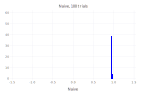

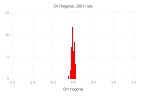

In [6]:
B = 100
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end

results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 100 trials")
))
display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 100 trials")
))


In [ ]:
#### B=1000 iterations

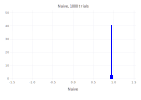

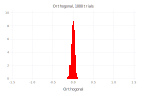

In [7]:
B = 1000
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end

results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 1000 trials")
))
display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 1000 trials")
))

In [ ]:
#### B=10000 iterations

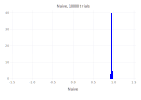

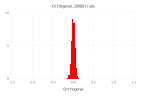

In [8]:
B = 10000
Naive = zeros(B)
Orthogonal = zeros(B)

#Multithreading 
Threads.@threads for i in 1:B
    
    #---(1) DGP simulation---#
    #------------------------#
    n = 10000
    p = 100
    beta = 1 ./ (1:p).^2    #px1 vector
    gamma = 1 ./ (1:p).^2   #px1 vector
    X = rand(Normal(0,1), n, p) #nxp matrix
    D = X * gamma + (rand(Normal(0,1), n, 1) / 4)  #nx1 vector
    Y = 10 * D + X * beta + rand(Normal(0,1), n, 1) #nx1 vector
    X1 = hcat(D,X)
    colnames_X = []
    colnames_D = [:D]
    colnames_Y = [:Y]
    colnames_X1 = [:D]
    for i in 1:100
        push!(colnames_X, Symbol("x$i"))
        push!(colnames_X1, Symbol("x$i"))
    end
    X_df = DataFrame(X, colnames_X)
    D_df = DataFrame(D, colnames_D)
    Y_df = DataFrame(Y, colnames_Y)
    X1_df = DataFrame(X1, colnames_X1)

    #---(2) Naive Learning---#
    #------------------------#
    #model1=rlasso_arg( X1_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #rlasso(model1)
    #coef1 = rlasso(model1)["coefficients"][3:102,2]                    
    #SX_IDs = findall(rlasso(model1)["coefficients"][3:102,2] .== 0 )   #idexes where b_hat=0
    df = hcat(Y_df, X1_df)
    varnames = names(df)[3:end]  
    formula_str = "D + " * join(varnames, " + ")
    expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

    model1=fit(LassoModel, expression, df)
    coef1 = coef(model1)
    SX_IDs = findall(coef1[3:102] .==0)

    #If all coefficients from X are 0 
    if (all(coef1[SX_IDs, :] .==0)) 
        Y1 = hcat(Y_df, D_df)
        Naive[i] = coef(lm(@formula(Y ~ D), Y1))[2] - 10
    end
    #If some coefficients from X are non-zero
    if (any(coef1[SX_IDs, :] .==0))
        Y2 = hcat(Y_df, D_df, X_df[:, SX_IDs])
        #Generating formula
        varnames = names(Y2)[3:end]                        #x_i from X_df[:, SX_IDs]
        formula_str = "D + " * join(varnames, " + ")
        expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))
        Naive[i] = (coef(lm(expression, Y2))[2]) - 10
    end


    #---(3) Orthogonal Learning---#
    #-----------------------------#
    #model2 =rlasso_arg( X_df, Y_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    #model3 =rlasso_arg( X_df, D_df ,nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )
    df2 = hcat(Y_df, X_df)
    df3 = hcat(D_df, X_df)

    varnames2 = names(df2)[2:end]  
    formula_str2 =  join(varnames2, " + ")
    expression2 = @eval(@formula(Y ~ $(Meta.parse(formula_str2))))
    varnames3 = names(df2)[2:end]  
    formula_str3 = join(varnames3, " + ")
    expression3 = @eval(@formula(D ~ $(Meta.parse(formula_str3))))

    model2=fit(LassoModel, expression2, df2)
    model3=fit(LassoModel, expression3, df3)

    resY = residuals(model2)
    resD = residuals(model3)
    df4 = DataFrame(hcat(resY,resD),["resY","resD"])
    Orthogonal[i] = coef(lm(@formula(resY ~ resD), df4))[2] - 10

    #resY = rlasso(model2)["residuals"]                  #Y cleared of effects from X
    #resD = rlasso(model3)["residuals"]                  #D cleared of effects from X
    #Y3=DataFrame(hcat(resY,resD),["resY","resD"])
    #Orthogonal[i] = coef(lm(@formula(resY ~ resD), Y3))[2] - 10

end

results = DataFrame(hcat(Naive,Orthogonal),["Naive","Orthogonal"])

display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Naive", Geom.histogram(bincount=10, density=true),
    color=[colorant"blue"]),
    Guide.title("Naive, 10000 trials")
))
display(Gadfly.plot(results, Coord.cartesian(xmin=-1.5, xmax=1.5),
    layer(x = "Orthogonal", Geom.histogram(bincount=10, density=true),
    color=[colorant"red"]),
    Guide.title("Orthogonal, 10000 trials")
))

Using parallel (multithreading) decreases the running time of all three loops. This is because multiple itereations can be excecuted at the same time, each by a single threadid. This way, we don't need to wait for one iteration to finish to start the next one. 

# Q3: Double Lasso - Using School data

In [39]:
import Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")

using CSV
using DataFrames

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`


In [40]:
df = CSV.read("C:/Users/ALBERTO TRELLES/Documents/Alberto/Ciclos/Ciclo 9/ML & causal inference/workgroup3/bruhn2016.csv", DataFrame)

#---Data Management---#
print(names(df))
colnames_df = [:Y, :D]
for i in 1:(size(df)[2]-2)
    push!(colnames_df, Symbol("x$i"))
end
df = DataFrame(df, colnames_df)

#Describing de dataset
for i in 1:(size(df, 2)-2)
    var = Symbol("x$i")
    print(describe(select(df, var)))
end

#x11 and x14 are index variables (treat them as floats)
df[!, :x11] = ifelse.(df[!, :x11] .== "NA", missing, df[!, :x11]); df[!, :x14] = ifelse.(df[!, :x14] .== "NA", missing, df[!, :x14])
df = dropmissing!(df, :x11); df = dropmissing!(df, :x14)
df.x11 = parse.(Float64, df.x11); df.x14 = parse.(Float64, df.x14)

["outcome.test.score", "treatment", "school", "is.female", "mother.attended.secondary.school", "father.attened.secondary.school", "failed.at.least.one.school.year", "family.receives.cash.transfer", "has.computer.with.internet.at.home", "is.unemployed", "has.some.form.of.income", "saves.money.for.future.purchases", "intention.to.save.index", "makes.list.of.expenses.every.month", "negotiates.prices.or.payment.methods", "financial.autonomy.index"]1×7 DataFrame
 Row │ variable  mean       min       median     max       nmissing  eltype   
     │ Symbol    Float64    Int64     Float64    Int64     Int64     DataType 
─────┼────────────────────────────────────────────────────────────────────────
   1 │ x1        3.25411e7  17000386  3.30936e7  53068181         0  Int641×7 DataFrame
 Row │ variable  mean     min      median   max      nmissing  eltype   
     │ Symbol    Nothing  String3  Nothing  String3  Int64     DataType 
─────┼─────────────────────────────────────────────────────────────

14771-element Vector{Float64}:
 52.0
 27.0
 56.0
 27.0
 31.0
 77.0
 43.0
 31.0
 50.0
 14.0
 56.0
 46.0
 37.0
  ⋮
 77.0
 41.0
 60.0
 52.0
 54.0
 62.0
 27.0
 43.0
 35.0
 24.0
 46.0
 -9.0

In [41]:
using GLM
varnames = names(df)[4:end]  
formula_str = "D + " * join(varnames, " + ")
expression = @eval(@formula(Y ~ $(Meta.parse(formula_str))))

model1 = lm(expression, df)   #GLM controls for missing values 
beta_D1 = coef(model1)[2]
ci_D1 = confint(model1)[2, :]

LoadError: UndefVarError: `coef` not defined